In [ ]:
# import zipfile

# with zipfile.ZipFile('/content/sketchdata.zip', 'r') as ref:
#   ref.extractall('/content/sketchdata')

In [1]:
import os
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import transforms
from PIL import Image
import random
import urllib.request
import numpy as np
import cv2

In [2]:
# Set the path to the folder containing the images
img_folder = '/content/photos/'

# Get a list of all the image files in the folder
image_files = [os.path.join(img_folder, f) for f in os.listdir(img_folder) if os.path.isfile(os.path.join(img_folder, f)) and f.endswith('.jpg')]

# print(image_files)

FileNotFoundError: ignored

In [ ]:
# Shuffle the image files randomly
random.shuffle(image_files)

# Set the split ratio
train_ratio = 0.7  # 70% of the images for training
valid_ratio = 0.3  # 30% of the images for validation

# Calculate the number of images for each set
num_train = int(len(image_files) * train_ratio)
num_valid = len(image_files) - num_train

# Read the images into memory
train_images = []
train_labels = []
valid_images = []
valid_labels = []

for i, image_file in enumerate(image_files):
    # Load the image and convert it to grayscale
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Split the filename to get the label
    label = os.path.basename(image_file).split('-')[0]
    
    # Add the image and label to the appropriate set
    if i < num_train:
        train_images.append(image)
        train_labels.append(label)
    else:
        valid_images.append(image)
        valid_labels.append(label)

# Convert the image and label lists to NumPy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)
valid_images = np.array(valid_images)
valid_labels = np.array(valid_labels)

# Print some statistics
print('Number of training images:', len(train_images))
print('Number of validation images:', len(valid_images))
print('Shape of a training image:', train_images[0].shape)


In [ ]:
# Convert the image and label lists to NumPy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)
valid_images = np.array(valid_images)
valid_labels = np.array(valid_labels)

# Print some statistics
# print('Number of training images:', len(train_images))
# print('Number of validation images:', len(valid_images))
# print('Shape of a training image:', train_images[0].shape)

# Define hyperparameters
batch_size = 32
learning_rate = 0.0002
num_epochs = 50

# Convert the image and label lists to PyTorch tensors
train_images = torch.from_numpy(train_images).unsqueeze(1).float()
train_labels = torch.from_numpy(train_labels).long()
valid_images = torch.from_numpy(valid_images).unsqueeze(1).float()
valid_labels = torch.from_numpy(valid_labels).long()

# Create TensorDataset objects for the training and validation sets
train_dataset = TensorDataset(train_images, train_labels)
valid_dataset = TensorDataset(valid_images, valid_labels)

# Create DataLoader objects for the training and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class GANLoss(nn.Module):
        def __init__(self, use_lsgan=True, target_real_label=1.0, target_fake_label=0.0):
            super(GANLoss, self).__init__()
            self.fake_label_var = None
            self.real_label_var = None
            self.real_label = target_real_label
            self.fake_label = target_fake_label
            self.Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
            if use_lsgan:
                self.loss = nn.MSELoss()
            else:
                self.loss = nn.BCEWithLogitsLoss()

        def get_target_tensor(self, input_img, target_is_real):
            target_tensor = None
            if target_is_real:
                create_label = ((self.real_label_var is None) or
                                (self.real_label_var.numel() != input_img.numel()))
                if create_label:
                    real_tensor = self.Tensor(input_img.size()).fill_(self.real_label)
                    self.real_label_var = nn.Parameter(real_tensor, requires_grad=False)
                target_tensor = self.real_label_var
            else:
                create_label = ((self.fake_label_var is None) or
                                (self.fake_label_var.numel() != input_img.numel()))
                if create_label:
                    fake_tensor = self.Tensor(input_img.size()).fill_(self.fake_label)
                    self.fake_label_var = nn.Parameter(fake_tensor, requires_grad=False)
                target_tensor = self.fake_label_var
            return target_tensor

        def forward(self, input_img, target_is_real):
            target_tensor = self.get_target_tensor(input_img, target_is_real)
            return self.loss(input_img, target_tensor.expand_as(input_img))

In [ ]:
class PerceptualLoss(nn.Module):
        def __init__(self, layers, weights, cuda):
            super(PerceptualLoss, self).__init__()
            self.layers = layers
            self.weights = weights
            self.vgg = models.VGG19(pretrained=True).features
            if cuda:
                self.vgg = self.vgg.cuda()
            for param in self.vgg.parameters():
                param.requires_grad = False

        def forward(self, x, y):
            x_vgg, y_vgg = self.vgg(x), self.vgg(y)
            loss = 0
            for i, layer in enumerate(self.layers):
                loss += self.weights[i] * F.l1_loss(x_vgg[layer], y_vgg[layer])
            return loss

In [ ]:
  class CycleConsistencyLoss(nn.Module):
        def __init__(self):
            super(CycleConsistencyLoss, self).__init__()

        def forward(self, x, y, x_recon, y_recon):
            return F.l1_loss(x, x_recon) + F.l1_loss(y, y_recon)

In [ ]:
class IdentityLoss(nn.Module):
        def __init__(self):
            super(IdentityLoss, self).__init__()

        def forward(self, x, y):
            return F.l1_loss(x, y)

In [ ]:
class PatchLoss(nn.Module):
        def __init__(self):
            super(PatchLoss, self).__init__()
            self.loss = nn.L1Loss()

        def get_masked_images(self, input, gt, gtsegmap, label):
            i, j = np.where(gtsegmap == label)
            mask = torch.zeros_like(gtsegmap, dtype=torch.float32)
            mask[i, j] = 1.0
            input_m = input * mask.cuda()
            gt_m = gt * mask.cuda()
            return input_m, gt_m

        def forward(self, input, gt, gtsegmap, label):
            gtsegmap = (gtsegmap + 1) * 5.0
            input_m, gt_m = self.get_masked_images(input, gt, gtsegmap, label)
            gt_m = gt_m.detach()
            return self.loss(input_m, gt_m)

In [ ]:
class FeatureMatchingLoss(nn.Module):
        def __init__(self, device):
            super(FeatureMatchingLoss, self).__init__()
            self.vgg = VGGNet().to(device)
            self.criterion = nn.L1Loss()

        def forward(self, real_img, fake_img, D):
            # Extract features from intermediate layers of the VGG network
            real_features = self.vgg(real_img, D)
            fake_features = self.vgg(fake_img, D)

            # Calculate the L1 loss between the real and fake features
            loss = 0
            for i in range(len(real_features)):
                loss += self.criterion(real_features[i], fake_features[i].detach())

            return loss

class VGGNet(nn.Module):
        def __init__(self):
            super(VGGNet, self).__init__()
            self.layer1 = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2))
            self.layer2 = nn.Sequential(
                nn.Conv2d(64, 128, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv2d(128, 128, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2))
            self.layer3 = nn.Sequential(
                nn.Conv2d(128, 256, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv2d(256, 256, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv2d(256, 256, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2))
            self.layer4 = nn.Sequential(
                nn.Conv2d(256, 512, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2))
            self.layer5 = nn.Sequential(
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2))
            self.layer6 = nn.Sequential(
                nn.Linear(25088, 4096),
                nn.ReLU(),
                nn.Dropout(),
                nn.Linear(4096, 4096),
                nn.ReLU(),
                nn.Dropout(),
                nn.Linear(4096, 1000),
                nn.ReLU())

        def forward(self, x, D):
            if D == 0:
                x = self.layer1(x)
                x = self.layer2(x)
                x = self.layer3(x)
                x = self.layer4(x)
                x = self.layer5(x)
            else:
                for i in range(D):
                    x = getattr(self, 'layer{}'.format(i + 1))(x)
            x = x.view(x.size(0), -1)
            x = self.layer6(x)
            return x

In [ ]:
# transform images to the same sizes
# transform = transforms.Compose([transforms.RandomResizedCrop(size = (224, 224)),
#                                 transforms.ToTensor()])

In [ ]:
# Initialize an empty list to store the images
image_dir = '/content/sketchdata/photo'
sketch_dir = '/content/sketchdata/original_sketch'

images = []
for file_name in os.listdir(image_dir):
    if file_name.endswith('.png') or file_name.endswith('.jpg'):
        image = Image.open(os.path.join(image_dir, file_name))
        image = transform(image)
        images.append(image)

sketches = []
for file_name in os.listdir(sketch_dir):
    if file_name.endswith('.png') or file_name.endswith('.jpg'):
        image = Image.open(os.path.join(sketch_dir, file_name))
        image = transform(image)
        sketches.append(image)

images_tensor = torch.stack(images)
sketches_tensor = torch.stack(sketches)

FileNotFoundError: ignored

In [ ]:
# # load images in
# class Data(Dataset):
#   def __init__(self, x): #, y):
#     self.x = x
#     # self.y = y

#   def __len__(self):
#     return len(self.x)
  
#   def __getitem__(self, index):
#     # transform images to the same sizes
#     transform = transforms.Compose([transforms.RandomResizedCrop(size = (224, 224)), transforms.ToTensor()])
#     image = self.x[index]
#     return transform(image)

In [ ]:
# Now load in eachdataset with the  dataloaders
def load_data(images_tensor=images_tensor, sketches_tensor=sketches_tensor):
  batch_size = 64
  # images_transformed = Data(images_tensor)
  # sketches_transformed = Data(sketches_tensor)
  
  images_loader = DataLoader(images_tensor, batch_size, shuffle=True, num_workers=2, pin_memory=True)
  sketches_loader = DataLoader(sketches_tensor, batch_size, shuffle=True, num_workers=2, pin_memory=True)

  return images_loader, sketches_loader

In [ ]:
plt.imshow(images_loader[0])

TypeError: ignored

TypeError: ignored

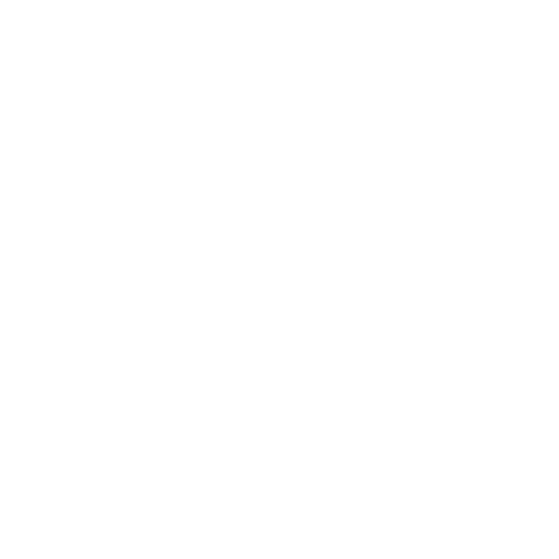

In [ ]:
# show the images
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def imshow(img, title=None):
    npimg = img.numpy()
    plt.figure(figsize=(15, 7))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

def show_batch_images(dataloader, k=2):
    images = next(iter(dataloader))
    images = images[:k]
    # labels = labels[:k]
    img = make_grid(images) #, padding=25)
    imshow(img) #, title=labels)

images_loader, sketches_loader = load_data()
for i in range(2):
    show_batch_images(images_loader)

In [ ]:
# def show_images(images, nmax=64):
#     fig, ax = plt.subplots(figsize=(8, 8))
#     ax.set_xticks([]); ax.set_yticks([])
#     ax.imshow(make_grid((images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
# def show_batch(dl, nmax=64):
#     for images in dl:
#         show_images(images, nmax)
#         break

In [ ]:
# images_loader, sketches_loader = load_data()
# show_batch(images_loader)

In [ ]:
image_dir = '/content/sketchdata/photo'
sketch_dir = '/content/sketchdata/original_sketch'

image_filenames = [name for name in os.listdir(image_dir) if os.path.splitext(name)[-1] == '.jpg']
# image_files = np.load(dir)
sketch_filenames = [name for name in os.listdir(sketch_dir) if os.path.splitext(name)[-1] == '.jpg']
# sketch_files = np.load(dir)

In [ ]:
image_tensor = torch.stack(image_filenames)
sketch_tensor = torch.stack(sketch_filenames)

TypeError: ignored

In [ ]:
class Generator(nn.Module):

  def __init__(self):

    super(Generator, self).__init__()

    self.first_stage = torch.nn.Conv2d(224, 224, 32)

    self.second_stage = torch.nn.Conv2d(28, 28, 256)
    self.third_stage = torch.nn.Conv2d(56, 56, 128)
    self.fourth_stage = torch.nn.Conv2d(112, 112, 64)
    one = torch.nn.Conv2d(1,1)
    three = torch.nn.Conv2d(3,3)
    m = torch.nn.Upsample(scale_factor=2, mode='bilinear')


  def forward(self, img):

    feature_maps = []

    output_img = torch.zeros(())

    for i in range(1, N - 1):
      f_m = feature_maps[i]
      upsampled_fm = m(f_m)
      f_m_1 = feature_maps[i + 1]
      upsampled_fm = torch.cat((f_m, upsampled_fm))
      ones_conv = one(upsampled_fm)
      threes_conv = three(ones_conv)

      feature_maps[i + 1] =  threes_conv


    return feature_maps[-1]




In [ ]:
class Discriminator(nn.Module):

  def __init__(self):

    self.first_layer = torch.nn.Conv2d(3, 32, 3, stride = 2, padding = 1)
    self.batch1 = torch.nn.BatchNorm2d(32, eps=1e-10)
    self.second_layer = torch.nn.Conv2d(32, 32, 3, stride = 2, padding = 1)
    self.batch2 = torch.nn.BatchNorm2d(32, eps=1e-10)
    self.third_layer = torch.nn.Conv2d(32, 64, 3, stride = 2, padding = 1)
    self.batch3 = torch.nn.BatchNorm2d(64, eps=1e-10)
    self.fourth_layer = torch.nn.Conv2d(64, 64, 3, stride = 2, padding = 1)
    self.batch4 = torch.nn.BatchNorm2d(64, eps=1e-10)
    self.fifth_layer = torch.nn.Conv2d(64, 128, 3, stride = 2, padding = 1)
    self.batch5 = torch.nn.BatchNorm2d(128, eps=1e-10)
    self.sixth_layer = torch.nn.Conv2d(128, 1, 3, stride = 1, padding = 1)
    self.batch6 = torch.nn.BatchNorm2d(1, eps=1e-10)
    self.sigmoid = torch.nn.sigmoid()
  
  def forward(self, img):

    first = F.relu(self.batch1(self.first_layer(img)))
    second = F.relu(self.batch2(self.second_layer(first)))
    third = F.relu(self.batch3(self.third_layer(second)))
    fourth = F.relu(self.batch4(self.fourth_layer(third)))
    fifth = F.relu(self.batch5(self.fifth_layer(fourth)))
    sixth = F.relu(self.batch6(self.sixth_layer(fifth)))
    output = self.sigmoid(sixth)


    return output


In [ ]:
from google.colab import drive
drive.mount('/content/drive')